In [1]:
import os
import re
import shutil
import string

import tensorflow as tf

import matplotlib.pyplot as plt

devices = tf.config.list_physical_devices("GPU")
print(devices)

try:
    tf.config.experimental.set_memory_growth(devices[0], True)
except:
    pass

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Sentiment analysis

### Download and explore the IMDB dataset

In [2]:
# 최초 다운로드 코드
# url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
# dataset = tf.keras.utils.get_file("aclImdb_v1", url, untar=True, cache_dir='.', cache_subdir='')
# dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

# 나는 따로 데이터셋을 모아놓는 폴더가 있기 때문에 직접 경로를 지정하여 진행.
# 없으면 아래 코드를 삭제하고, 위 코드의 주석 처리를 풀고 사용.
dataset_dir = 'D:\\dataset\\aclImdb'

os.listdir(dataset_dir)

['test', 'train', 'imdbEr.txt', 'imdb.vocab', 'README']

In [3]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['neg',
 'pos',
 'unsupBow.feat',
 'labeledBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

In [4]:
sample_file = os.path.join(train_dir, 'pos\\1181_9.txt')
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


### Load dataset

In [5]:
# 코드를 처음부터 새로 실행하는 경우를 위해 예외처리.
try:
    remove_dir = os.path.join(train_dir, 'unsup')
    shutil.rmtree(remove_dir)
except:
    pass

- `text_dataset_from_directory` 기능을 사용하여 `tf.data.Dataset`을 만듦.

In [6]:
batch_size = 32
seed = 111

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [7]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print('Review: ', text_batch.numpy()[i])
        print('Label: ', label_batch.numpy()[i])

Review:  b"Really enjoyed this little movie. It's a moving film about struggle, sacrifice and especially the bonds of friendship between different peoples (the child actor who plays Miki is especially good). There's so many large scale impersonal films set around WW2, that this convincingly told little story is a real break from the norm, and an original one at that. I'll also add that this film is far from boring, very far!! Of course the Horses are wonderful and the scenery breathtaking. To anyone who really treats their animal as part of the family (I do), you'll find this film especially rewarding. Recommended to movie fans who look for something a little different."
Label:  1
Review:  b"the acting itself wasn't even that bad, since it did't come to mind in the movie but whatever had this director in mind? the intended climb towards some climax completely missed the mark,..<br /><br />almost all scenes involve acting that stand so far from our own intentions and way of reacting on 

In [8]:
print('Label 0 corresponds to', raw_train_ds.class_names[0])
print('Label 1 corresponds to', raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [9]:
raw_validation_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [10]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    os.path.join(dataset_dir, 'test'),
    batch_size=batch_size
)

Found 25000 files belonging to 2 classes.


### Prepare the dataset for training

`tf.keras.layers.Textvectorization` 레이어를 사용하여 데이터를 표준화(Standardization), 토큰화(Tokenization), 벡터화(Vectorization) 시킴
- 표준화 : 데이터 세트를 단순화하기 위해, 구두점이나 HTML 요소를 제거하기 위한 전처리
- 토큰화 : 문자열을 토큰으로 분할하는 것. (예: 한 문장을 여러 개의 단어들로 쪼갬)
- 벡터화 : 토큰을 숫자로 변화하여 신경망에 제공할 수 있도록 함.


- `<br />`과 같은 HTML 태그들은 `Textvectorization` 레이어의 기본 기능으로는 제거되지 않는다. 따라서 그에 맞는 함수를 만들어 적용

In [11]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ') # regex_replace: 입력값에서 일치하는 패턴을 다시쓰기
    return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '') # 정규식을 사용하여 특수문자 없애기

In [12]:
max_features = 10000
sequence_length = 250

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization, # 표준화에 직접 만든 함수 사용
    max_tokens=max_features, # 레이어의 최대 어휘 수
    output_mode='int', # 레이어의 출력
    output_sequence_length=sequence_length # 'int'모드에서만 사용 가능. 시간 차원이 이 값으로 채워지거나 잘림
)

- `adapt`를 사용하여 적용. 학습 데이터에만 적용. 검증 데이터에 사용하면 정보가 누출됨. 중요!!

In [13]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

- 전처리 결과 확인

In [14]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [15]:
text_batch, label_batch = next(iter(raw_train_ds))

first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b"The idea of making a miniseries about the Berlin airlift seemed to me as one of the more interesting German (post)war movies. It is a theme that has not been explored much as yet. However, the makers of this series stuffed it with clich\xc3\xa9s. It starts already with the DVD cover of the movie, which is a direct copy of the cover of 'Pearl Harbor'.<br /><br />Luise Kielberg (Bettina Zimmermann) gets to hear that her husband, who is a doctor, (Ulrich Noethen) has died in Russia and after the war she's struggling to survive. She finds a job at the American base, gets to work for the coolest and highest ranking officer (Heino Ferch) in town, falls in love with 'm, gets pregnant, and all of a sudden her husband turns up again. Come on!!! We've seen this once too often. Heino Ferch and Ulrich Noethen play their role quite well; Bettina Zimmermann however never really seems to convince. For some reason it always seems she's somewhat too late in giving the right emotional

- 정수로 대체된 토큰들은 레이어에서 `get_vocabulary`를 호출하여 각 정수에 해당하는 토큰을 조회할 수 있다.

In [16]:
print('62 : ', vectorize_layer.get_vocabulary()[62])
print('1562 : ', vectorize_layer.get_vocabulary()[1562])
print('69 : ', vectorize_layer.get_vocabulary()[69])
print('16 : ', vectorize_layer.get_vocabulary()[16])
print('29 : ', vectorize_layer.get_vocabulary()[29])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

62 :  really
1562 :  moved
69 :  me
16 :  with
29 :  its
Vocabulary size: 10000


In [17]:
train_ds = raw_train_ds.map(vectorize_text)
validation_ds = raw_validation_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configure the dataset for performance

'I/O'가 차단되지 않도록 데이터를 로드할 때 사용하는 두 가지 중요한 메소드.
- `cache` : 로드된 후, 데이터를 메모리에 유지. 모델이 학습하는 동안 데이터 세트 병목현상이 일어나지 않음.
- `prefecth` : 학습하는 동안 데이터의 전처리와 모델 실행을 병렬로 진행.

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

In [19]:
embedding_dim = 16

In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features + 1, embedding_dim),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

### Loss function and optimizer

In [22]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=tf.metrics.BinaryAccuracy(threshold=0.0)
    )

### Train the model

In [23]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs
)

Epoch 1/10
625/625 [==============================] - 23s 33ms/step - loss: 0.6640 - binary_accuracy: 0.6859 - val_loss: 0.6183 - val_binary_accuracy: 0.7658
Epoch 2/10
625/625 [==============================] - 5s 8ms/step - loss: 0.5504 - binary_accuracy: 0.7977 - val_loss: 0.5027 - val_binary_accuracy: 0.8182
Epoch 3/10
625/625 [==============================] - 5s 8ms/step - loss: 0.4459 - binary_accuracy: 0.8458 - val_loss: 0.4244 - val_binary_accuracy: 0.8444
Epoch 4/10
625/625 [==============================] - 6s 9ms/step - loss: 0.3783 - binary_accuracy: 0.8668 - val_loss: 0.3776 - val_binary_accuracy: 0.8604
Epoch 5/10
625/625 [==============================] - 5s 9ms/step - loss: 0.3352 - binary_accuracy: 0.8802 - val_loss: 0.3486 - val_binary_accuracy: 0.8674
Epoch 6/10
625/625 [==============================] - 6s 9ms/step - loss: 0.3047 - binary_accuracy: 0.8899 - val_loss: 0.3287 - val_binary_accuracy: 0.8718
Epoch 7/10
625/625 [==============================] - 5s 9ms/s

### Evaluate the model

In [24]:
loss, accuracy = model.evaluate(test_ds)

print('Loss: ', loss)
print('Accuracy: ', accuracy)

782/782 [==============================] - 74s 93ms/step - loss: 0.3157 - binary_accuracy: 0.8682
Loss:  0.31574204564094543
Accuracy:  0.8682000041007996


### Create a plot of accuracy and loss over time

- `model.fit`은 학습 중 발생한 모든 것이 사전형 `history` 객체를 반환함

In [25]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [26]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

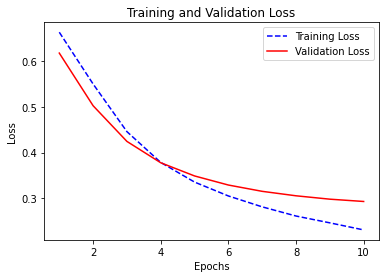

In [27]:
plt.plot(epochs, loss, 'b--', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

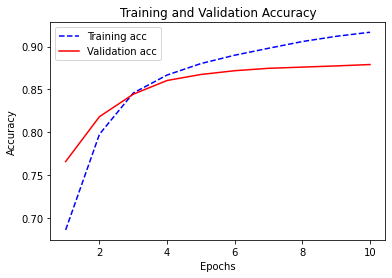

In [28]:
plt.plot(epochs, acc, 'b--', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Export the model

위에서 모델을 학습하기 전에 이미 데이터셋에 `Textvectorization` 레이어를 적용시켰다.<br>그러나, 이 레이어를 모델에 추가하여 텍스트 테이터를 바로 모델이 추론할 수 있도록 만들 수 있다.

In [29]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    tf.keras.layers.Activation('sigmoid')
])

export_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)

In [30]:
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 11s 14ms/step - loss: 0.3157 - accuracy: 0.8682
0.8682000041007996


### Inference on new data

In [33]:
examples = [
    'The movie was great!',
    'The movie was not bad.',
    'The movie was terrible...',
    'The movie was not funny.',
    'I did not enjoy this movie.'
]

export_model.predict(examples)

1/1 [==============================] - 0s 49ms/step


array([[0.6288235 ],
       [0.3365439 ],
       [0.36326745],
       [0.47084403],
       [0.542487  ]], dtype=float32)